### NICO

This implementation is based on the matlab code by M. Rabbat (see ./matlab/ folder of this repo).

Example: inference of a network with n nodes from T observations of length Nm.

In [1]:
import numpy as np
from random import shuffle, random
from scipy.special import gamma as gamma_function
from scipy.sparse import csr_matrix
import itertools
from math import log

Initialize parameters

In [2]:
n = 6 #number of nodes in the network
T = 100 #number of paths
Nm = 5 #number of nodes per path
np.random.seed(1337)

In [3]:
# initial probabilities of a Markov model
A = np.random.rand(n, n)
A = A / A.sum(axis = 1, keepdims=True)
pi = np.random.rand(n, 1)
pi = pi / pi.sum(axis=0, keepdims=True)

Generate some paths according to this Markov model

In [4]:
X = np.zeros((T, Nm))

In [5]:
# Generate the order as random numbers for testing purposes.
R_out = np.random.rand(T,1)
R_in = np.random.rand(T, Nm)

In [6]:
cumprobs = pi.cumsum(axis = 0)

In [7]:
# iterator is required to preserve the order of permutations
iterator = 0
for walk in X:
#     Sample the starting node from Pi
#     larger = (cumprobs >= random()).nonzero()
    larger = (cumprobs >= R_out[iterator][0]).nonzero()
    walk[0] = larger[0][0]
#     Sample remaining nodes in the path by taking a random walk
    for i in range(1, Nm):
        cumprobs_in = A[int(walk[i - 1]),:].cumsum(axis=0)
#       larger = (cumprobs >= random()).nonzero()
        larger = (cumprobs_in >= R_in[iterator][i]).nonzero()
        walk[i] = larger[0][0]
    iterator += 1
X = X.astype(int)

Shuffle observations

In [8]:
# Y = X.copy()
# for walk in Y:
#     shuffle(walk)

In [9]:
# numTrials = 50

Utils

In [10]:
def normalize_csr_rows(csr_mat):
    """
    Normalize sparse csr_matrix by row.
    In place.
    """
    row_sums = np.array(csr_mat.sum(axis=1))[:,0]
    row_indices, col_indices = csr_mat.nonzero()
    csr_mat.data /= row_sums[row_indices]

In [11]:
def normalize_csr_columns(csr_mat):
    """
    Normalize sparse csr_matrix by column.
    In place.
    """
    col_sums = np.array(csr_mat.sum(axis=0))[0,:]
    row_indices, col_indices = csr_mat.nonzero()
    csr_mat.data /= col_sums[col_indices]

In [12]:
def permutation_probabilities(bag_of_nodes, pi_hat, A_hat, full_probs = True):
    """
    Evaluate all permutations of a path (bag_of_nodes).
    
    pi_hat and A_hat - initial parameters.
    
    full_probs - flag. 
    If True, computes and returns probability parameters for every permutation. 
    If False, computes and returns the sum.
    """
    n = len(bag_of_nodes)
    
    permutation_orders = list(itertools.permutations(list(range(n))))
    
    gamma = np.zeros(n)
    Gamma = np.zeros((n,n))
    probability = 0
    
    # Compute likelihood of this link ordering
    for order in permutation_orders:
        starting_node = order[0]
        p = pi_hat[bag_of_nodes[starting_node]]
        
        for i in range(1, n):
            p = p * A_hat[bag_of_nodes[order[i - 1]], bag_of_nodes[order[i]]]
        
        # Store the results for every permutation
        if full_probs:
            gamma[order[0]] += p
        
            for i in range(1, n):
                Gamma[order[i - 1]][order[i]] += p
        else:
            probability += p
    
    if full_probs:
        return gamma, Gamma
    else:
        return probability

In [13]:
def loglik(X, A, pi):
    """
    Computes loglikelihood P(X | A, Pi).
    """
    ll = 0
    for walk in X:
        l = len(walk)
        p = 0
        for i in range(l):
            p = permutation_probabilities(walk, pi, A, full_probs=False)
        ll += log(p) - log(gamma_function(l + 1))
    return ll

NICO implementation

In [14]:
def nico(X, n):
    """
    Core of NICO algorithm.
    
    X - Cell array of co-occurrence data.  Each cell contains one unordered list (column vector) of nodes in a path
    n - Number of nodes in the network

    Returns:
    A_hat - Estimated transition matrix
    pi_hat - Estimated initial state distribution
    """
    #number of nodes in each path
#     size = lambda array: len(array)
#     Nm = np.apply_along_axis(size, 1, X)
    
    #Initialize pi_hat
    #Assume all states appear at least once in the data
    pi_hat = 1 + 0.3 * np.random.rand(n, 1)
    pi_hat = pi_hat / pi_hat.sum(axis = 0, keepdims = True)
    pi_hat = [item[0] for item in pi_hat]
    
    # Construct A_hat as a sparse matrix
    # First determine an upperbound on the number of non-zero entries
    ii = []
    jj = []

    for walk in X:
        V = np.array(list(itertools.combinations(walk, 2)))
        ii.append(list(V[:, 0]))
        jj.append(list(V[:, 1]))

    ii = [item for sublist in ii for item in sublist]
    jj = [item for sublist in jj for item in sublist]
    ss = np.ones(len(ii))
    
    A_hat = csr_matrix((ss, (ii, jj)), shape = (n,n))
    A_hat = (A_hat + A_hat.transpose()) / 2
    A_hat_copy = A_hat.copy()
    A_hat_copy.data.fill(1)
    
    A_hat = A_hat_copy + 0.4 * csr_matrix((np.random.random((A_hat.nnz)),A_hat.nonzero()), shape=A_hat.shape)
    
    #Normalize A_hat
    normalize_csr_columns(A_hat)
    A_hat = A_hat.transpose()
    
    # EM algorithm
    tol = 0.01
    kmax = 100
    for k in range(kmax):
        # E-STEP
        #Test on one permutation
        r_alpha_gamma = []
        r_alpha_Gamma = []

        for bag_of_nodes in X:
            gamma, Gamma = permutation_probabilities(bag_of_nodes, pi_hat, A_hat)
            gamma_sum = sum(gamma)
            r_alpha_gamma.append(gamma/gamma_sum)
            r_alpha_Gamma.append(Gamma/gamma_sum)

        # M-STEP
        #1. Sum probabilities for gamma
        c = np.zeros(n)
        for seq, probs in zip(X, r_alpha_gamma):
            for node_id in range(n):
                node_indexes = [i for i, j in enumerate(seq) if j == node_id]
                c[node_id] += probs[node_indexes].sum()

        #2. Sum probabilities for Gamma
        C = np.zeros((n,n))
        for seq, probs in zip(X, r_alpha_Gamma):
            l = len(seq)
            for i in range(l - 1):
                for j in range(i + 1, l):
                    C[(seq[i],seq[j])] += probs[(i,j)]
                    C[(seq[j],seq[i])] += probs[(j,i)]

        A_hat_old = A_hat.copy()
        pi_hat_old = pi_hat.copy()

        A_hat = csr_matrix(C)
        pi_hat = c

        #Normalize
        pi_hat = pi_hat / pi_hat.sum(axis = 0, keepdims = True)
        normalize_csr_rows(A_hat)

        # Compute change in Q
        Q = 0
        Q_old = 0
        for seq, probs in zip(X, r_alpha_gamma):
            l = len(seq)
            for node_id in range(l):
                Q += probs[node_id] * log(pi_hat[seq[node_id]])
                Q_old += probs[node_id] * log(pi_hat_old[seq[node_id]])

        for seq, probs in zip(X, r_alpha_Gamma):
            l = len(seq)
            for i in range(l - 1):
                for j in range(i + 1, l):
                    Q += probs[(i,j)] * log(A_hat[(seq[i], seq[j])] + np.finfo(float).eps)
                    Q += probs[(j,i)] * log(A_hat[(seq[j], seq[i])] + np.finfo(float).eps)

                    Q_old += probs[(i,j)] * log(A_hat_old[(seq[i], seq[j])] + np.finfo(float).eps)
                    Q_old += probs[(j,i)] * log(A_hat_old[(seq[j], seq[i])] + np.finfo(float).eps)

        delta = Q - Q_old

        # Check stopping criterion
        sc = delta / tol
        
        print("Iter: {0} || Delta: {1:.2f} || Q: {2:.2f}".format(k + 1, delta, Q))
        
        if k == kmax - 1:
            print("Number of EM iterations exceeded the limit.")
        
        if sc < 1:
            print("Terminated successfully after {0} iterations.".format(k + 1))
            break
    
    return pi_hat, A_hat

In [15]:
# %%time
# pi_hat, A_hat = nico(X, n)

NICO trials

In [16]:
num_trials = 1
ll = []
l1 = []
for i in range(num_trials):
    print("Trial {0}:".format(i + 1))
    pi_hat, A_hat = nico(X, n)
    ll.append(loglik(X, A_hat, pi_hat))
    l1.append(np.sum(np.abs(A_hat - A)) + np.sum(np.abs(pi_hat - pi.flatten())))

Trial 1:
Iter: 1 || Delta: 22.19 || Q: -875.58
Iter: 2 || Delta: 2.42 || Q: -866.84
Iter: 3 || Delta: 0.87 || Q: -859.51
Iter: 4 || Delta: 0.33 || Q: -854.42
Iter: 5 || Delta: 0.14 || Q: -851.06
Iter: 6 || Delta: 0.07 || Q: -848.79
Iter: 7 || Delta: 0.05 || Q: -847.17
Iter: 8 || Delta: 0.04 || Q: -845.92
Iter: 9 || Delta: 0.04 || Q: -844.85
Iter: 10 || Delta: 0.04 || Q: -843.87
Iter: 11 || Delta: 0.04 || Q: -842.91
Iter: 12 || Delta: 0.04 || Q: -841.92
Iter: 13 || Delta: 0.04 || Q: -840.86
Iter: 14 || Delta: 0.05 || Q: -839.71
Iter: 15 || Delta: 0.05 || Q: -838.46
Iter: 16 || Delta: 0.06 || Q: -837.07
Iter: 17 || Delta: 0.06 || Q: -835.56
Iter: 18 || Delta: 0.06 || Q: -833.90
Iter: 19 || Delta: 0.07 || Q: -832.09
Iter: 20 || Delta: 0.07 || Q: -830.13
Iter: 21 || Delta: 0.07 || Q: -828.04
Iter: 22 || Delta: 0.08 || Q: -825.82
Iter: 23 || Delta: 0.08 || Q: -823.49
Iter: 24 || Delta: 0.08 || Q: -821.06
Iter: 25 || Delta: 0.08 || Q: -818.56
Iter: 26 || Delta: 0.08 || Q: -816.00
Iter: 27 ||

In [17]:
A_hat.todense()

matrix([[1.91714848e-01, 8.77779737e-02, 1.52482869e-01, 1.25149274e-01,
         2.57121500e-02, 4.17162885e-01],
        [4.08588962e-06, 4.46993683e-01, 1.06730072e-01, 2.48245776e-01,
         1.33943084e-01, 6.40832981e-02],
        [7.27040238e-06, 3.30626402e-01, 2.12214164e-01, 7.58500258e-06,
         2.41093838e-01, 2.16050741e-01],
        [2.80459254e-01, 1.11174024e-06, 2.91209717e-01, 9.65509698e-02,
         3.31737861e-01, 4.10867131e-05],
        [1.94047129e-01, 1.88653611e-07, 2.69037876e-01, 4.17263197e-07,
         1.40183944e-01, 3.96730446e-01],
        [1.58139396e-03, 4.18980274e-01, 1.06342811e-01, 1.04091029e-01,
         2.47900979e-01, 1.21103512e-01]])

In [34]:
# Threshold
t = A_hat.multiply(A_hat > A_hat.mean())

Visualization

In [60]:
import networkx as nx
from matplotlib import pyplot as plt

In [36]:
graph = nx.Graph(t.todense())

In [50]:
pos = nx.spring_layout(graph)

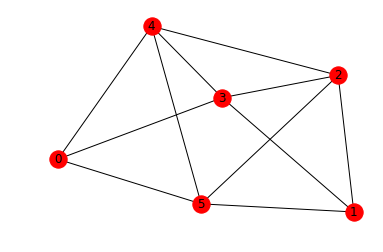

In [69]:
nx.draw_networkx_nodes(graph, pos)
nx.draw_networkx_edges(graph, pos)
nx.draw_networkx_labels(graph, pos)
plt.axis('off')
plt.show()

Export to GEXF

In [68]:
import uuid
nx.write_gexf(graph, './gexf/graph_' + uuid.uuid4().hex + '.gexf')